In [1]:
# Group Number: 23
# Roll Numbers: 22CD91F01(Nazeer Haider), 20CS10076(Vishal Ravipati), 22CS60R57(Yerragorla Krishna Mohan)
# Project Number: PSSVM
# Project Title: Pulsar Star Classification using Support Vector Machines

# Importing models
import numpy as np 
from numpy import linalg 
from cvxopt import solvers
import cvxopt.solvers                  # cvxopt for solving the dual optimization problem 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('pulsar_star_dataset.csv')
df.head()                                                           # reading the dataset

,MoIP,SDoIP,EkIP,SoIP,MoDM-SNR,SDDM-SNR,EkDM-SNR,SoDM-SNR,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [3]:
X = df.drop('Class', axis=1)
y = df['Class']                                                                                     # splitting the dataset into features and labels
X = X.to_numpy()
y = y.to_numpy()                                                                                    # converting the dataset into numpy array for ease of use
y[y == 0] = -1                                                                                      # converting the labels to -1 and 1, as per the SVM problem formulation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)           # splitting the dataset into train and test set
mean_train = X_train.mean()                                                                         # standardizing the dataset
std_train = X_train.std()
X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train                                                          # standardizing the test set using the mean and standard deviation of the train set

In [4]:
class SVM(object):

    def linear_kernel(self, x1, x2):                                                            # defining the kernel functions, using numpy vectorisation to speed up the process
        return np.dot(x1, x2) * 1.                                                              # multiplying here and elsewhere by 1. to convert to float required by cvxopt

    def quadratic_kernel(self, x1, x2):
        return ((1 + np.dot(x1, x2))*1.) ** 2                                

    def gaussian_kernel(self, x1, x2):   
        x2 = x2.T                                           
        X_norm = np.sum(x1 ** 2, axis = -1)
        Y_norm = np.sum(x2 ** 2, axis = -1)
        return np.exp(-self.gamma * (X_norm[:,None] + Y_norm[None,:] - 2 * np.dot(x1, x2.T)))   # expanding || x- y || ^2 = || x || ^2 + || y || ^2 - 2 * x.T * y

    def __init__(self, kernel_str='linear', C=1.0, gamma=0.1):                                 # initializing the SVM class
        if kernel_str == 'linear':
            self.kernel = SVM.linear_kernel
        elif kernel_str == 'quadratic':
            self.kernel = SVM.quadratic_kernel
        elif kernel_str == 'gaussian':
            self.kernel = SVM.gaussian_kernel
        else:
            self.kernel = SVM.linear_kernel
            print('Invalid kernel string, defaulting to linear.')
        self.C = C
        self.gamma = gamma
        self.kernel_str = kernel_str
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        num_samples, num_features = X.shape
        kernel_matrix = np.zeros((num_samples, num_samples))                                                    # creating the kernel matrix
        kernel_matrix = self.kernel(self, X, X.T)

        P = cvxopt.matrix(np.outer(y,y) * kernel_matrix)                                                    # creating the matrices for the dual optimization problem, derivation explained in report
        q = cvxopt.matrix(np.ones(num_samples) * -1)
        A = cvxopt.matrix(y, (1,num_samples)) * 1.
        b = cvxopt.matrix(0) * 1.                                                                                        
        G_upper = np.diag(np.ones(num_samples) * -1)
        G_lower = np.identity(num_samples)
        G = cvxopt.matrix(np.vstack((G_upper, G_lower)))
        h_upper = np.zeros(num_samples)
        h_lower = np.ones(num_samples) * self.C
        h = cvxopt.matrix(np.hstack((h_upper, h_lower)))

        solvers.options['show_progress'] = False                                                            # turning off the progress bar of cvxopt
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)                                                      # running the qp solver of cvxopt to solve the dual optimization problem
        a = np.ravel(solution['x'])                                                                         # get the lagrange multipliers from the solution
        support_vectors = a > 1e-4                                                                          # get the support vectors which have non-zero lagrange multipliers
        ind = np.arange(len(a))[support_vectors]                                                            # get the indices of the support vectors for the kernel matrix
        self.a = a[support_vectors]                                                                         # storing the data of the solution in the svm object
        self.support_vectors = X[support_vectors]
        self.y_support_vectors = y[support_vectors]
        print("%d support vectors out of %d points" % (len(self.a), num_samples))

        self.b = 0                                                                                          # deriving the bias value by enforcing the constraint for b in the svm optimization problem
        for n in range(len(self.a)):
            self.b += self.y_support_vectors[n]
            self.b -= np.sum(self.a * self.y_support_vectors * kernel_matrix[ind[n],support_vectors])
        self.b /= len(self.a)

        if self.kernel_str == 'linear':                                                                     # deriving the weights for the linear kernel
            self.w = np.zeros(num_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.y_support_vectors[n] * self.support_vectors[n]
        else:
            self.w = None                                                                                   # if the kernel is not linear, then the weights are not defined

    def predict(self, X):
        if self.kernel_str == 'linear':                                                                     # if linear, then the prediction is given by the linear combination of the support vectors
            return np.sign(np.dot(X, self.w) + self.b)
        else:
            y_predict = np.sum(self.a * self.y_support_vectors * self.kernel(self, X, self.support_vectors.T), axis=1)  # if not linear, then the prediction is given by the kernel modification to the standard linear version
            y_predict = np.sign(y_predict + self.b)                                                         
            return y_predict                                                                                # returning the sign of the prediction (positive meaning +1, negative meaning -1)

In [5]:
# note that running on the full dataset is very slow (3-4 hours), so uncomment the code below and run this cell if you wish to check the results more quickly or apply grid search, comment it out again before running the full dataset
X_train = X_train[:800]
y_train = y_train[:800]
X_test = X_test[:200]
y_test = y_test[:200]

In [6]:
clf_linear = SVM('linear', 1.0)                                                                             
clf_linear.fit(X_train, y_train)
y_pred_linear = clf_linear.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred_linear))

75 support vectors out of 800 points
Accuracy:  0.97


In [7]:
clf_quadratic = SVM('quadratic', 1.0)
clf_quadratic.fit(X_train, y_train)
y_pred_quadratic = clf_quadratic.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred_quadratic))

66 support vectors out of 800 points
Accuracy:  0.965


In [8]:
clf_gaussian = SVM('gaussian', 1.0, 0.1)
clf_gaussian.fit(X_train, y_train)
y_pred_gaussian = clf_gaussian.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred_gaussian))

96 support vectors out of 800 points
Accuracy:  0.955


In [9]:
confusion_matrix(y_test, y_pred_linear)

array([[172,   3],
       [  3,  22]], dtype=int64)

In [10]:
confusion_matrix(y_test, y_pred_quadratic)

array([[172,   3],
       [  4,  21]], dtype=int64)

In [11]:
confusion_matrix(y_test, y_pred_gaussian)

array([[173,   2],
       [  7,  18]], dtype=int64)

In [12]:
sk_clf_linear = svm.SVC(kernel='linear', C=1.0)
sk_clf_linear.fit(X_train, y_train)
sk_y_pred_linear = sk_clf_linear.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, sk_y_pred_linear))

Accuracy:  0.94


In [13]:
sk_clf_quadratic = svm.SVC(kernel='poly', degree=2, C=1.0)
sk_clf_quadratic.fit(X_train, y_train)
sk_y_pred_quadratic = sk_clf_quadratic.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, sk_y_pred_quadratic))

Accuracy:  0.935


In [14]:
sk_clf_gaussian = svm.SVC(kernel='rbf', C=10, gamma=0.1)
sk_clf_gaussian.fit(X_train, y_train)
sk_y_pred_gaussian = sk_clf_gaussian.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, sk_y_pred_gaussian))

Accuracy:  0.95


In [17]:
# Define the hyperparameters
C_values = [0.1, 1, 10, 100, 1000]

# Train and evaluate SVM with linear kernel
linear_accuracies = []
for C in C_values:
    svm_linear = SVM('linear', C=C)
    svm_linear.fit(X_train, y_train)
    y_pred_linear = svm_linear.predict(X_test)
    linear_accuracies.append(accuracy_score(y_test, y_pred_linear))

# Train and evaluate SVM with quadratic kernel
quadratic_accuracies = []
for C in C_values:
    svm_quadratic = SVM('quadratic', C=C)
    svm_quadratic.fit(X_train, y_train)
    y_pred_quadratic = svm_quadratic.predict(X_test)
    quadratic_accuracies.append(accuracy_score(y_test, y_pred_quadratic))
    

# Print the results
print("-"*65)
print("Kernel\t\t\t Hyperparameters (C)\t Accuracy")
print("-"*65)
for i, C in enumerate(C_values):
    print(f"Linear\t\t\t C={C}\t\t\t accuracy={linear_accuracies[i]}")
    
for i, C in enumerate(C_values):
    print(f"Quadratic\t\t C={C}\t\t\t accuracy={quadratic_accuracies[i]}")

97 support vectors out of 800 points
75 support vectors out of 800 points
68 support vectors out of 800 points
66 support vectors out of 800 points
62 support vectors out of 800 points
78 support vectors out of 800 points
66 support vectors out of 800 points
60 support vectors out of 800 points
58 support vectors out of 800 points
51 support vectors out of 800 points
-----------------------------------------------------------------
Kernel			 Hyperparameters (C)	 Accuracy
-----------------------------------------------------------------
Linear			 C=0.1			 accuracy=0.955
Linear			 C=1			 accuracy=0.97
Linear			 C=10			 accuracy=0.975
Linear			 C=100			 accuracy=0.97
Linear			 C=1000			 accuracy=0.985
Quadratic		 C=0.1			 accuracy=0.965
Quadratic		 C=1			 accuracy=0.965
Quadratic		 C=10			 accuracy=0.965
Quadratic		 C=100			 accuracy=0.97
Quadratic		 C=1000			 accuracy=0.975


In [18]:
# Define the hyperparameters
C_values = [0.1, 1, 10, 100, 1000]
gamma_values = [0.1, 1, 10, 100, 1000]

# Train and evaluate SVM with Gaussian RBF kernel
rbf_accuracies = []
for C in C_values:
    for gamma in gamma_values:
        svm_rbf = SVM('gaussian', C=C, gamma=gamma)
        svm_rbf.fit(X_train, y_train)
        y_pred_rbf = svm_rbf.predict(X_test)
        rbf_accuracies.append((C, gamma, accuracy_score(y_test, y_pred_rbf)))
        

# Print the results
print("Gaussian RBF kernel:")
print("-"*65)
print("Hyperparameters (C)\t Hyperparameters (gamma)\t Accuracy")
print("-"*65)
for C, gamma, accuracy in rbf_accuracies:
    print(f"C={C}\t\t\t gamma={gamma}\t\t\t accuracy={accuracy}")

153 support vectors out of 800 points
150 support vectors out of 800 points
286 support vectors out of 800 points
703 support vectors out of 800 points
800 support vectors out of 800 points
96 support vectors out of 800 points
105 support vectors out of 800 points
267 support vectors out of 800 points
704 support vectors out of 800 points
800 support vectors out of 800 points
80 support vectors out of 800 points
98 support vectors out of 800 points
237 support vectors out of 800 points
666 support vectors out of 800 points
800 support vectors out of 800 points
64 support vectors out of 800 points
71 support vectors out of 800 points
206 support vectors out of 800 points
667 support vectors out of 800 points
800 support vectors out of 800 points
64 support vectors out of 800 points
77 support vectors out of 800 points
116 support vectors out of 800 points
672 support vectors out of 800 points
800 support vectors out of 800 points
Gaussian RBF kernel:
------------------------------------

In [21]:
#GridSearch using sklearn GridSearchCV() and SVC() classes
grid_values = {'gamma' : [0.1, 1, 10, 100, 1000], 'C' : [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(estimator=svm.SVC(), param_grid=grid_values, cv=10, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

#Print the best score and configuration
print("Best params: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best params: 0.970000 using {'C': 10, 'gamma': 0.1}


In [22]:
#Print table using DataFrame()
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_C','param_gamma', 'mean_test_score']]

,param_C,param_gamma,mean_test_score
0,0.1,0.1,0.94875
1,0.1,1,0.96000
2,0.1,10,0.90750
3,0.1,100,0.90750
4,0.1,1000,0.90750
5,1,0.1,0.96500
6,1,1,0.96875
7,1,10,0.96125
8,1,100,0.91125
9,1,1000,0.90750


In [27]:
#Apply PCA for reduce the dimention
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [28]:
clf_gaussian = SVM('gaussian', 10, 1)
clf_gaussian.fit(X_train, y_train)
y_pred_gaussian = clf_gaussian.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred_gaussian))

193 support vectors out of 800 points
Accuracy:  0.96


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


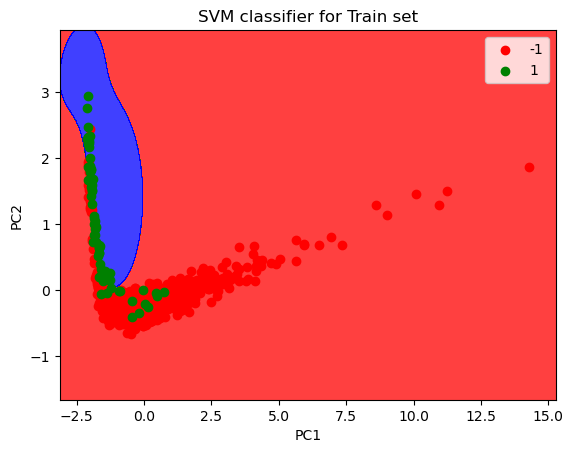

In [29]:
#For Train set
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
X1, X2 = np.meshgrid(np.arange(start = X_train[:, 0].min() - 1, stop = X_train[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_train[:, 1].min() - 1, stop = X_train[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf_gaussian.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == j, 0], X_train[y_train == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('SVM classifier for Train set')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


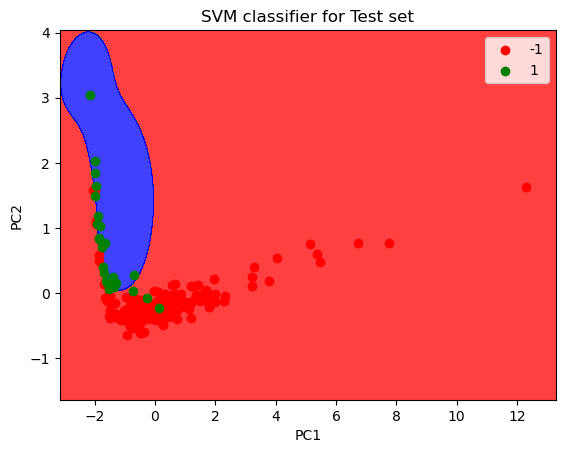

In [30]:
#For Test set
from matplotlib.colors import ListedColormap
X1, X2 = np.meshgrid(np.arange(start = X_test[:, 0].min() - 1, stop = X_test[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_test[:, 1].min() - 1, stop = X_test[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf_gaussian.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_test)):
    plt.scatter(X_test[y_test == j, 0], X_test[y_test == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('SVM classifier for Test set')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()